# **0. Import and Data Loading**

We will load the preprocessed dataset that was prepared earlier in the Jupyter Notebook.

In [1]:
# Library
import pandas as pd
import numpy as np
import os


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering
from imblearn.pipeline import Pipeline
from category_encoders import BinaryEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler

# Model Selection
from sklearn.metrics import recall_score, accuracy_score
from sklearn.model_selection import cross_val_score
from mlxtend.evaluate import GroupTimeSeriesSplit
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier


# Set max columns
pd.set_option('display.max_columns', None)

In [2]:
folder_path = os.path.join("dataset", "03_ML_dataset",'churn_dataset.csv')
df = pd.read_csv(folder_path)

In [3]:
pd.DataFrame({
    'total': df.shape[0],
    'null_count': df.isna().sum(),
    'null_pct':   [f"{val:.2f}%" for val in (df.isna().sum() / df.shape[0] * 100)],
    'unique_count': df.nunique(),
    'dtype': df.dtypes
}).rename_axis('column')

,total,null_count,null_pct,unique_count,dtype
column,,,,,
seller_active_quarter,5124,0,0.00%,5,object
year,5124,0,0.00%,2,int64
quarter,5124,0,0.00%,4,int64
seller_id,5124,0,0.00%,2158,object
is_churn,5124,0,0.00%,2,bool
n_orders,5124,0,0.00%,167,int64
n_approved_orders,5124,0,0.00%,169,int64
n_delivered_carrier,5124,0,0.00%,163,int64
n_orders_late_to_carrier,5124,0,0.00%,37,int64


In [4]:
df['seller_active_quarter'] = pd.PeriodIndex(df['seller_active_quarter'], freq='Q-DEC')
df = df.set_index('seller_active_quarter').sort_index()
df

,year,quarter,seller_id,is_churn,n_orders,n_approved_orders,n_delivered_carrier,n_orders_late_to_carrier,n_delivered_customers,sales,n_orders_late_to_customer,median_approve_time,median_review_score,tenure_months,last_month_active_quarter,n_months_active_quarter,seller_city,seller_state
seller_active_quarter,,,,,,,,,,,,,,,,,,
2017Q1,2017,1,seller_1526,False,1,1,0,0,0,0.00,0,15.466667,0.0,1,3,1,sao paulo,SP
2017Q1,2017,1,seller_2743,False,34,34,32,1,30,4977.69,1,10.650000,5.0,4,3,3,sao paulo,SP
2017Q1,2017,1,seller_2382,True,3,3,3,0,3,84.60,0,0.000000,4.5,2,3,2,sao roque,SP
2017Q1,2017,1,seller_1375,False,1,1,1,0,1,145.00,0,10.216667,4.0,1,2,1,sao paulo,SP
2017Q1,2017,1,seller_464,False,2,2,2,0,2,336.80,0,6.625000,4.5,3,3,2,guarulhos,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018Q1,2018,1,seller_458,True,2,2,2,0,2,167.00,0,24.366667,3.0,1,2,1,sao paulo,SP
2018Q1,2018,1,seller_329,False,11,11,11,0,16,2408.47,4,33.100000,1.0,15,3,3,sao paulo,SP
2018Q1,2018,1,seller_1759,False,2,2,2,0,1,45.99,0,1953.625000,1.0,1,3,1,sao paulo,SP


In [5]:
df['is_churn'] = df['is_churn'].astype('int64')
df['is_churn']

seller_active_quarter
2017Q1    0
2017Q1    0
2017Q1    1
2017Q1    0
2017Q1    0
         ..
2018Q1    1
2018Q1    0
2018Q1    0
2018Q1    0
2018Q1    0
Freq: Q-DEC, Name: is_churn, Length: 5124, dtype: int64

In [6]:
df

,year,quarter,seller_id,is_churn,n_orders,n_approved_orders,n_delivered_carrier,n_orders_late_to_carrier,n_delivered_customers,sales,n_orders_late_to_customer,median_approve_time,median_review_score,tenure_months,last_month_active_quarter,n_months_active_quarter,seller_city,seller_state
seller_active_quarter,,,,,,,,,,,,,,,,,,
2017Q1,2017,1,seller_1526,0,1,1,0,0,0,0.00,0,15.466667,0.0,1,3,1,sao paulo,SP
2017Q1,2017,1,seller_2743,0,34,34,32,1,30,4977.69,1,10.650000,5.0,4,3,3,sao paulo,SP
2017Q1,2017,1,seller_2382,1,3,3,3,0,3,84.60,0,0.000000,4.5,2,3,2,sao roque,SP
2017Q1,2017,1,seller_1375,0,1,1,1,0,1,145.00,0,10.216667,4.0,1,2,1,sao paulo,SP
2017Q1,2017,1,seller_464,0,2,2,2,0,2,336.80,0,6.625000,4.5,3,3,2,guarulhos,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018Q1,2018,1,seller_458,1,2,2,2,0,2,167.00,0,24.366667,3.0,1,2,1,sao paulo,SP
2018Q1,2018,1,seller_329,0,11,11,11,0,16,2408.47,4,33.100000,1.0,15,3,3,sao paulo,SP
2018Q1,2018,1,seller_1759,0,2,2,2,0,1,45.99,0,1953.625000,1.0,1,3,1,sao paulo,SP


# **1. Introduction**

Olist operates as an online marketplace platform generating revenue primarily through sales commissions. While buyers are numerous, they typically make single purchases, whereas sellers—though fewer in number—contribute significantly higher per-entity profit through both sales commissions and platform subscription fees.

Sellers represent a critical stakeholder in our business model, not only generating more revenue per individual compared to buyers, but also providing the products available in the Olist store. 

## **1.1 Data Understanding**

Our dataset for churn analysis consists of observations for each seller active in each quarter. Each record represents a seller active in a specific quarter, with a churn label indicating whether they will remain active in the subsequent quarter. The `seller_active_quarter` field serves as an index for splitting data during cross-validation and train/test partitioning for out-of-time testing (see Section 3.2 for more details).

Key variables in our dataset include:

- **`year`**: Year during which a seller is active
- **`quarter`**: Quarter during which a seller is active
- **`seller_id`**: Unique identifier for each seller
- **`is_churn`**: Binary indicator of whether the seller remains active in the following quarter
- **`n_orders`**: Count of unique orders received in a quarter
- **`n_approved_orders`**: Count of unique orders approved in a quarter
- **`n_delivered_carrier`**: Count of unique orders delivered to carriers in a quarter
- **`n_orders_late_to_carrier`**: Count of unique orders delivered late to carriers in a quarter
- **`n_delivered_customers`**: Count of unique orders delivered to customers in a quarter
- **`sales`**: Total revenue generated by a seller in a quarter before commission cut in R$
- **`n_orders_late_to_customer`**: Count of unique orders delivered late to customers in a quarter
- **`median_approve_time`**: Median duration for a seller to approve purchases in a quarter
- **`median_review_score`**: Median customer review rating received by a seller in a quarter (0-5 scale)
- **`tenure`**: Total months a seller has been active on the platform up to the given quarter
- **`n_months_active_quarter`**: Number of months a seller was active within the specific quarter (1-3)
- **`last_month_active_quarter`**: Final month within the quarter in which a seller was active (1-3)
- **`seller_city`**: City where the seller is registered
- **`seller_state`**: State where the seller is registered

## **1.2 Objective**

Like many service-based businesses, sellers—whom we consider our primary customers—may discontinue using Olist's services over time, either voluntarily or involuntarily. This phenomenon, known as *churn*, often correlates with their satisfaction with the platform.

Maintaining relationships with sellers is critical for business success and churn reduction. Losing a seller, particularly high-performing ones, can significantly reduce our commission-based profits. Moreover, if we lose sellers who supply high-value, high-quality items with limited alternative suppliers, we risk compromising our competitive advantage.

While we recognize the importance of prioritizing seller who are about to churn, managing relationships becomes increasingly challenging as our seller base expands. The key questions we aim to address are:

1. How can we identify sellers who are likely to churn?

2. If the seller is going to churn, are they high-priority or low-priority candidate to focus on?

3. Is our model good at predicting which candidates to focus on?

## **1.3 The Plan**

This analysis and modeling initiative aims to develop a framework that will help the **Account Manager team** identify and prioritize sellers requiring focused attention. Our approach includes:

1. Segmenting sellers into **Profitable** and **Unprofitable** categories (Section 2.1)
2. Further classifying active sellers in a quarter as **Top** or **Regular** sellers based on their last year's history (Section 2.2)
3. Calculating cost estimates associated with **Top** and **Regular** sellers for our model (Section 2.2.3)
4. Developing our predictive model for churn identification (Section 3 - Section 11)

# **2. Pre-Modeling Data Analysis**

## **2.1 Profitable and Unprofitable Sellers**

In this section, we will examine the profitable and unprofitable segments within our churn dataset. 

Profitability is defined as follows: 

* Sellers are required to pay a monthly subscription fee to list their items on the Olist store. 

* For each month a seller remains active, they generate revenue from sales. 

* **A seller is considered profitable if their total revenue during active months is at least bigger than their total subscription costs for those same months.**

In [7]:
# For reusability in cost calculation later
def filter_profitable_sellers(
    df, 
    monthly_subscription_cost, 
    sales_commission_rate, 
    profitability='profitable'
):
    """
    Filter seller IDs based on their profitability, comparing net sales (after commission) 
    to their total subscription costs over active months.

    Parameters:
    - df (pd.DataFrame): Input DataFrame with seller data.
    - monthly_subscription_cost (float): Monthly subscription cost for sellers.
    - sales_commission_rate (float): Commission rate applied to sales.
    - profitability (str): Profitability filter, either 'profitable' (net sales after commission >= subscription costs) 
      or 'unprofitable' (net sales after commission < subscription costs).

    Returns:
    - pd.Series: Filtered seller IDs.
    """
    net_sales = lambda x: x["sales"].sum() * (1 - sales_commission_rate)
    total_subscription_cost = lambda x: x["n_months_active_quarter"].sum() * monthly_subscription_cost

    if profitability == 'profitable':
        return df.groupby("seller_id").filter(
            lambda x: net_sales(x) >= total_subscription_cost(x)
        )["seller_id"]
    elif profitability == 'unprofitable':
        return df.groupby("seller_id").filter(
            lambda x: net_sales(x) < total_subscription_cost(x)
        )["seller_id"]
    else:
        raise ValueError("Invalid profitability filter. Use 'profitable' or 'unprofitable'.")

In [8]:
profitable_sellers_data = df[df['seller_id'].isin(filter_profitable_sellers(df, 39, 0.18))]
unprofitable_sellers_data = df[df['seller_id'].isin(filter_profitable_sellers(df, 39, 0.18, 'unprofitable'))]

In [9]:
print(f"On average, profitable sellers receive {int(np.ceil(profitable_sellers_data["n_orders"].median()))} orders per quarter")
print(f"On average, unprofitable sellers receive {int(np.ceil(unprofitable_sellers_data["n_orders"].median()))} orders per quarter")

On average, profitable sellers receive 5 orders per quarter
On average, unprofitable sellers receive 1 orders per quarter


Our analysis indicates that, on average, profitable sellers receive significantly more orders (5) compared to unprofitable sellers (1). 

Based on the insights from `02. Data Cleaning and Analysis`, we learned that **prioritizing sellers with more than two orders is advantageous**. 

Consequently, **it is unlikely that investing resources in supporting unprofitable sellers will yield significant benefits for the company**.

In [10]:
profitable_sellers_data["Segment"] = "Profitable Seller"
unprofitable_sellers_data["Segment"] = "Unprofitable Seller"

profitable_unprofitable_data = pd.concat([profitable_sellers_data, unprofitable_sellers_data], axis=0)

/tmp/ipykernel_51155/3111163785.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profitable_sellers_data["Segment"] = "Profitable Seller"
/tmp/ipykernel_51155/3111163785.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unprofitable_sellers_data["Segment"] = "Unprofitable Seller"


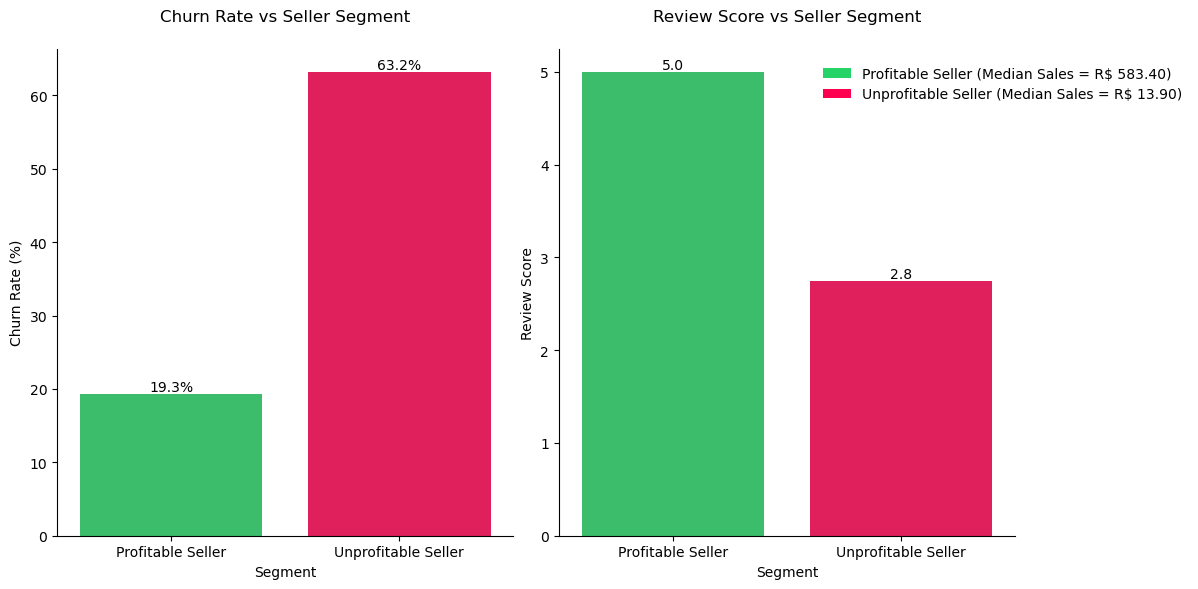

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.barplot(data=profitable_unprofitable_data,
            x="Segment",
            y="is_churn",
            estimator=lambda x: x.mean() * 100,
            ax=ax[0],
            hue="Segment",
            palette={"Profitable Seller": "#25D366", "Unprofitable Seller": "#FF0051"},
            errorbar=None)

ax[0].set_title("Churn Rate vs Seller Segment", pad=20)
ax[0].set_ylabel("Churn Rate (%)")
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)


for j, bar in enumerate(ax[0].patches):
    width = bar.get_width()
    height = bar.get_height()
    ax[0].text(bar.get_x() + width/2, height,
                f'{height:.1f}%',
                va='bottom', ha='center')



sns.barplot(data=profitable_unprofitable_data,
            x="Segment",
            y="median_review_score",
            estimator="median",
            ax=ax[1],
            hue="Segment",
            palette={"Profitable Seller": "#25D366", "Unprofitable Seller": "#FF0051"},
            errorbar=None)

ax[1].set_title("Review Score vs Seller Segment", pad=20)
ax[1].set_ylabel("Review Score")
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)

for j, bar in enumerate(ax[1].patches):
    width = bar.get_width()
    height = bar.get_height()
    ax[1].text(bar.get_x() + width/2, height,
                f'{height:.1f}',
                va='bottom', ha='center')


# Calculate median sales for each segment
median_sales_profitable = profitable_unprofitable_data.query("Segment == 'Profitable Seller'")["sales"].median()
median_sales_unprofitable = profitable_unprofitable_data.query("Segment == 'Unprofitable Seller'")["sales"].median()

# Create custom legend
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor='#25D366', label=f'Profitable Seller (Median Sales = R$ {median_sales_profitable:,.2f})'),
    Patch(facecolor='#FF0051', label=f'Unprofitable Seller (Median Sales = R$ {median_sales_unprofitable:,.2f})')
]

# Add legend to the right of the plots, positioned higher
fig.legend(handles=legend_elements,
          loc='center right',
          bbox_to_anchor=(1.0, 0.85),
          frameon=False)

# Adjust layout to prevent cutting off the legend
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Make room for the legend

plt.show()

The analysis of the segments reveals that unprofitable sellers demonstrate both a higher churn rate and lower review scores compared to their profitable counterparts.

These unprofitable sellers not only have higher churn rate, but they also generate substantially lower sales (and therefore less commission cut for olist).

Given these metrics, **implementing intervention strategies for unprofitable sellers who show signs of churning, as such efforts would likely be ineffective in preventing their departure and would not provide meaningful business benefits.**

Moving forward, we will further divide the profitable seller segment into two categories: regular sellers and top sellers. The specific definitions and methodology for identifying top versus regular sellers will be elaborated in the upcoming section addressing Cost Calculation and Metric Selection.

## **2.2 Cost Calculation and Metric Selection**

In this section, we establish criteria to classify sellers into two categories: top sellers and regular sellers. Our classification process involves the following steps:

1. We first calculate last years' net sales for all profitable sellers

2. For each quarter, we analyze the sellers' history one year prior

3. Among active sellers in that quarter, we identify:
   - **Top sellers**: Those in the top 20th percentile of net sales last year
   - **Regular sellers**: Those in the bottom 80th percentile of net sales last year


Next, we will apply this segmentation to the test data, which corresponds to the last quarter (`2018Q1`) in our dataset (`df`). 

For both Top and Regular Sellers, we will calculate their median sales, which will subsequently be used to estimate the costs of False Negatives (FN), False Positives (FP), and True Positives (TP) in our binary classification model.


### **2.2.1 Function Definition**

In [12]:
def get_profitable_seller_sales_year(df, monthly_subscription_cost, sales_commission_rate, period_start, period_end):
    """
    Calculate sales metrics for profitable sellers over a one-year period.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing seller data with date index
    - monthly_subscription_cost (float): Monthly subscription cost for sellers
    - sales_commission_rate (float): Commission rate applied to sales
    - period_start (str): Start of the period (e.g., '2017Q1')
    - period_end (str): End of the period (e.g., '2017Q4')
    
    Returns:
    - pd.DataFrame: DataFrame with seller_id, median_sales, and net_sales for profitable sellers
    """
    # Check if period covers exactly one year (assuming quarterly data)
    if period_start[-2] == 'Q' and period_end[-2] == 'Q':
        start_year = int(period_start[:-2])
        end_year = int(period_end[:-2])
        start_quarter = int(period_start[-1])
        end_quarter = int(period_end[-1])
        
        # Calculate total quarters between start and end
        total_quarters = (end_year - start_year) * 4 + (end_quarter - start_quarter + 1)
        
        if total_quarters != 4:
            raise ValueError(f"Period must span exactly one year (4 quarters). Current span: {total_quarters} quarters")
    
    # Filter data for the specified period
    df_filtered_period = df.query("index >= @period_start and index <= @period_end")
    
    # Identify profitable sellers
    profitable_sellers_id = filter_profitable_sellers(
        df_filtered_period, 
        monthly_subscription_cost, 
        sales_commission_rate
    )
    
    # Filter data for profitable sellers
    df_filtered_period = df_filtered_period[df_filtered_period.seller_id.isin(profitable_sellers_id)]
    
    # Calculate sales metrics
    seller_sales = df_filtered_period.groupby("seller_id").agg(
        median_sales=("sales", "median"),
        net_sales=("sales", "sum")
    ).reset_index()
    
    return seller_sales

In [13]:
def check_priority_sellers(test_data, seller_sales_year, segment='top_20_pct'):
    """
    Create a mask for data points belonging to the specified seller segment.
    
    Parameters:
    - test_data (pd.DataFrame): Data to evaluate (must have seller_id and sales columns)
    - seller_sales_year (pd.DataFrame): Reference sales data with metrics
    - segment (str): Segment to filter for: 'top_20_pct' or 'regular'
    
    Returns:
    - pd.Series: Boolean mask indicating which rows match the specified segment
    """
    # Filter seller_sales_year to all sellers in test data
    seller_sales_test = seller_sales_year[seller_sales_year.seller_id.isin(test_data["seller_id"])]

    # Identify top sellers based on net sales
    top_sellers_list = seller_sales_test[
        seller_sales_test.net_sales >= seller_sales_test.net_sales.quantile(0.80)
    ]["seller_id"]
    
    # Create masks based on the specified segment
    if segment == 'top_20_pct':
        mask = (test_data['seller_id'].isin(top_sellers_list))
    elif segment == 'regular':
        mask = (~test_data['seller_id'].isin(top_sellers_list)) & (test_data['seller_id'].isin(seller_sales_test["seller_id"]))
    else:
        raise ValueError("Invalid segment. Use 'top_20_pct' or 'regular'.")
    
    return mask

### **2.2.2 Top and Regular Segmentation for Test Data (2018Q1)**

In [14]:
# Calculate seller sales for the reference year
seller_sales_year = get_profitable_seller_sales_year(df, 39, 0.18, '2017Q1', '2017Q4')
seller_sales_year

,seller_id,median_sales,net_sales
0,seller_0,109.350,218.70
1,seller_1,2189.395,10643.19
2,seller_1006,669.300,1763.69
3,seller_1007,108.345,216.69
4,seller_1009,520.990,520.99
...,...,...,...
1454,seller_987,3920.295,7840.59
1455,seller_988,823.850,1647.70
1456,seller_995,3674.000,3674.00
1457,seller_996,421.300,842.60


In [15]:
# Get data for 2018Q1 (test data)
test_seller_ids = df.query("index >= '2018Q1' and index < '2018Q2'")[["seller_id"]]
test_seller_ids

,seller_id
seller_active_quarter,
2018Q1,seller_2878
2018Q1,seller_421
2018Q1,seller_1696
2018Q1,seller_67
2018Q1,seller_1761
...,...
2018Q1,seller_458
2018Q1,seller_329
2018Q1,seller_1759


In [16]:
# Get seller IDs for top sellers in 2018Q1 
top_test_seller_ids = test_seller_ids.loc[check_priority_sellers(test_seller_ids, seller_sales_year), "seller_id"]
top_test_seller_ids

seller_active_quarter
2018Q1      seller_67
2018Q1     seller_797
2018Q1    seller_2001
2018Q1     seller_513
2018Q1    seller_1182
             ...     
2018Q1    seller_1781
2018Q1     seller_120
2018Q1     seller_167
2018Q1    seller_1253
2018Q1    seller_2191
Freq: Q-DEC, Name: seller_id, Length: 187, dtype: object

In [17]:
# Get seller IDs for regular sellers in 2018Q1 
regular_test_seller_ids = test_seller_ids.loc[check_priority_sellers(test_seller_ids, seller_sales_year, 'regular'), "seller_id"]
regular_test_seller_ids

seller_active_quarter
2018Q1    seller_2878
2018Q1     seller_421
2018Q1    seller_1696
2018Q1    seller_1761
2018Q1     seller_316
             ...     
2018Q1    seller_1220
2018Q1    seller_2601
2018Q1     seller_329
2018Q1     seller_180
2018Q1    seller_1021
Freq: Q-DEC, Name: seller_id, Length: 747, dtype: object

### **2.2.3 Cost Estimate Calculation for Test Data (2018Q1)**

In [18]:
top_seller_med_sales = seller_sales_year.loc[seller_sales_year.seller_id.isin(top_test_seller_ids), "median_sales"].median()
regular_seller_med_sales = seller_sales_year.loc[seller_sales_year.seller_id.isin(regular_test_seller_ids), "median_sales"].median()

print(f"Median Sales for Tep Sellers in 2018Q1: R$ {top_seller_med_sales}")
print(f"Median Sales for Regular Sellers in 2018Q1: R$ {regular_seller_med_sales}")

Median Sales for Tep Sellers in 2018Q1: R$ 3471.4
Median Sales for Regular Sellers in 2018Q1: R$ 477.25


In [19]:
fn_cost_top = np.round(0.18 * top_seller_med_sales)
fn_cost_regular =  np.round(0.18 * regular_seller_med_sales)

print(f"FN Cost for Tep Sellers in 2018Q1: R$ {fn_cost_top}")
print(f"FN Cost for Regular Sellers in 2018Q1: R$ {fn_cost_regular}")

FN Cost for Tep Sellers in 2018Q1: R$ 625.0
FN Cost for Regular Sellers in 2018Q1: R$ 86.0


In [20]:
print(f"Number of Sellers in 2018Q1: {test_seller_ids.shape[0]}")
print(f"Number of Top Sellers in 2018Q1: {top_test_seller_ids.shape[0]}")
print(f"Number of Regular Sellers in 2018Q1: {regular_test_seller_ids.shape[0]}")

Number of Sellers in 2018Q1: 1381
Number of Top Sellers in 2018Q1: 187
Number of Regular Sellers in 2018Q1: 747


In [21]:
fp_cost_top = np.round(0.02 * top_seller_med_sales + 36 + 40 + 5) # 1 hour CRM per quarter for each seller, 40 for marketing, 5 coupon
fp_cost_regular = np.round(0.01 * regular_seller_med_sales + 5)

print(f"FP Cost for Tep Sellers in 2018Q1: R$ {fp_cost_top}")
print(f"FP Cost for Regular Sellers in 2018Q1: R$ {fp_cost_regular}")

FP Cost for Tep Sellers in 2018Q1: R$ 150.0
FP Cost for Regular Sellers in 2018Q1: R$ 10.0


In [22]:
p_targeting_success_top = 0.30
p_targeting_success_regular = 0.15

tp_cost_top = np.round(0.18 * top_seller_med_sales * p_targeting_success_top - fp_cost_top)
tp_cost_regular =  np.round(0.18 * regular_seller_med_sales * p_targeting_success_regular - fp_cost_regular)

print(f"TP Cost for Tep Sellers in 2018Q1: R$ {tp_cost_top}")
print(f"TP Cost for Regular Sellers in 2018Q1: R$ {tp_cost_regular}")

TP Cost for Tep Sellers in 2018Q1: R$ 37.0
TP Cost for Regular Sellers in 2018Q1: R$ 3.0


### **2.2.4 Cost Estimate Breakdown for Seller Churn Prediction Model**

#### **Key Metrics**

Commission Cut: 18%

| Metric | Top Sellers | Regular Sellers |
|--------|------------|----------------|
| Median Quarterly Sales | R$3,471.40 | R$477.25 |
| Retention Success Rate | 30% (assumption)| 15% (assumption)|

#### **False Negative (FN) Cost**
*When a churning seller is incorrectly predicted to remain*

| Seller Type | Calculation | Cost |
|-------------|-------------|------|
| Top Seller | 18% × R$3,471.40 = R$625.0 | R$625.0 |
| Regular Seller | 18% × R$477.25 = R$86.0 | R$86.0 |

#### **False Positive (FP) Cost**
*When a non-churning seller is incorrectly predicted to churn*

| Seller Type | Calculation | Cost |
|-------------|-------------|------|
| Top Seller | (2% × R$3,471.40) + R$36 (CRM) + R$40 (marketing) +  R$5 (voucher) = R$150.0 | R$150.0 |
| Regular Seller | (1% × R$477.25) + R$5 (voucher) = R$10.0 | R$10.0 |

**Notes for FP Costs:**
- **Discount for Top and Regular Sellers:**
    - 2% sales cut for Top Sellers
    - 1% sales cut for Regular Sellers

- **CRM Support for Top Sellers:**
  - Cost: R$36 (Source: Glassdoor Brazil, 2018 adjusted salary data for account managers).
- **Marketing Assistance for Top Sellers:**
  - Assumed Maximum Budget: Up to R$700/month for paid media advertising (Based on: Agência E-Plus).
  - Context: Sellers provide items, but Olist manages the online stores on other platforms. The cost reflects the items provided by the seller.
  - Allocation:
    - Total top sellers in test data: 187.
    - Assumed churn rate for budget planning purposes (not the actual test churn rate): 20% (based on churn rate of the profiting seller segment).
    - Estimated churning top sellers: 187 × 20% ≈ 38.
    - Per-seller marketing cost: R$40 (as included in the FP cost calculation).
    - Total monthly marketing cost for churning top sellers: R$40 × 38 = R$1,520.
    - Quarterly budget check: R$1,520 ÷ 3 ≈ R$507/month, which is within the R$700/month marketing budget.

#### **True Positive (TP) Cost Reduction/Benefit**
*When a churning seller is correctly predicted to churn and interventions are applied*

| Seller Type | Intervention | Success Rate | Calculation | Cost |
|-------------|--------------|--------------|-------------|------------|
| Top Seller | 2% commission reduction + CRM + voucher + marketing help | 30% | (18% × R$3,471.40 × 30%) - R$150.0 = R$37.0 | - R$37.0 |
| Regular Seller | 1% commission reduction + voucher | 15% | (18% × R$477.25 × 15%) - R$10.0 = R$3.0 | - R$3.0 |



#### **Sources**
- Seller sales data: Olist ecommerce platform database (2018)
- Marketing budget data: [Agência E-Plus](https://www.agenciaeplus.com.br/en/quanto-investir-em-trafego-pago/)
- Account Manager salary information: [Glassdoor Brazil, Account Manager salary data (Adjusted to 2018 rates)](https://www.glassdoor.com/)

# **3. Modeling**
We will develop a binary classification model to predict seller churn. This model will serve account managers who oversee seller relationships. Prediction results will focus specifically on Top and Regular seller segments. Account managers will then analyze these predictions alongside historical seller data to determine appropriate and tailored interventions for at-risk sellers.

## **3.1 Metric Selection**
Since FN Cost is bigger than FP Cost, we will use **Recall** as our primary metric to optimize. Recall is defined as:

$$ \text{Recall} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Negative}}$$

By optimizing Recall, we will minimize the cost due to False Negative errors in our model. 

## **3.2 Out-of-Time Validation**
Our testing and validation methodology is time-dependent, as our e-commerce data exhibits clear temporal patterns. 

As demonstrated below, seller behavior is not time-independent. E-commerce typically displays seasonality, with churn rates fluctuating throughout the year. 

The data shows that churn rates in 2017Q3 tend to be lower, which, according to our previous analysis in notebook "02. Data Cleaning and Analysis," may be attributed to the upcoming Black Friday and holiday season in the following quarter.


In [23]:
df.reset_index().groupby("seller_active_quarter").agg(churn_rate=("is_churn", "mean"))

,churn_rate
seller_active_quarter,
2017Q1,0.257230
2017Q2,0.244444
2017Q3,0.216832
2017Q4,0.243286
2018Q1,0.241854


**Conventional random cross-validation assumes time independence between observations, which doesn't apply to our data**. Random splitting could leak temporal information between training and test sets, compromising our ability to evaluate future predictions based on historical data.

**E-commerce seller behavior usually shows seasonal patterns and responds to market dynamics**. Random splits distribute these patterns across both sets, preventing the model from learning time-based relationships.

We'll implement an **expanding-window out-of-time validation** approach instead. This method trains on historical data and validates on subsequent periods, preserving temporal structure. With each iteration, the training window expands while always validating on future periods.

**This approach mimics production scenarios where models are trained on available historical data and deployed on new, unseen future data**. This validation strategy better estimates how the model will perform with evolving market conditions and seller behaviors.

We'll use `GroupTimeSeriesSplit` with `seller_active_quarter` as our time index for these temporal splits, ensuring our validation respects chronological order of our data, training on past quarters and validating on future ones, as illustrated in the diagram below.


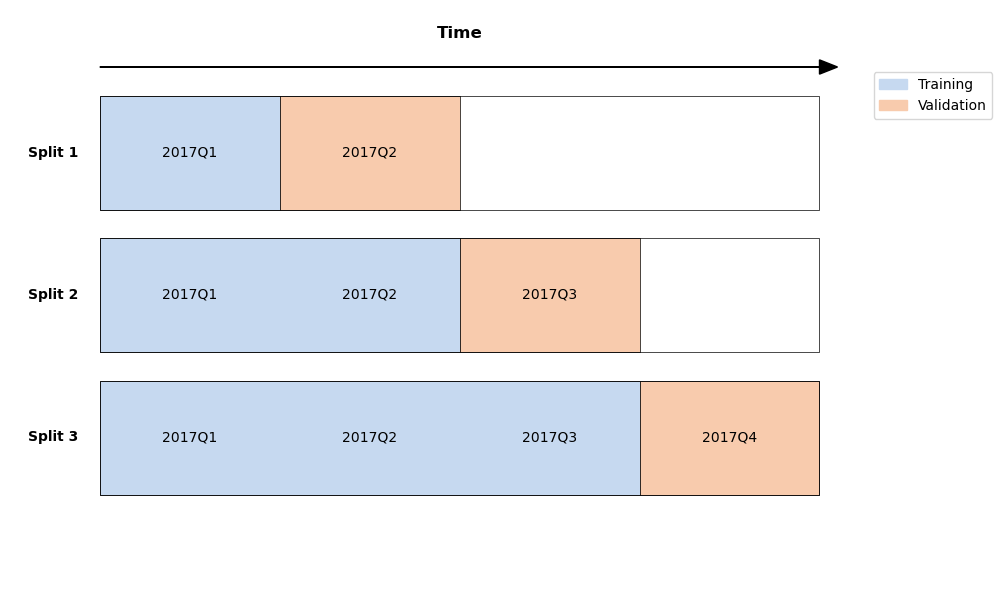

# **4. Cleaning and Feature Engineering for Modeling**

## **4.1 Outlier Handling**

In [24]:
numerical_cols = df.drop(columns='is_churn').select_dtypes(include=['number']).columns
numerical_cols

Index(['year', 'quarter', 'n_orders', 'n_approved_orders',
       'n_delivered_carrier', 'n_orders_late_to_carrier',
       'n_delivered_customers', 'sales', 'n_orders_late_to_customer',
       'median_approve_time', 'median_review_score', 'tenure_months',
       'last_month_active_quarter', 'n_months_active_quarter'],
      dtype='object')

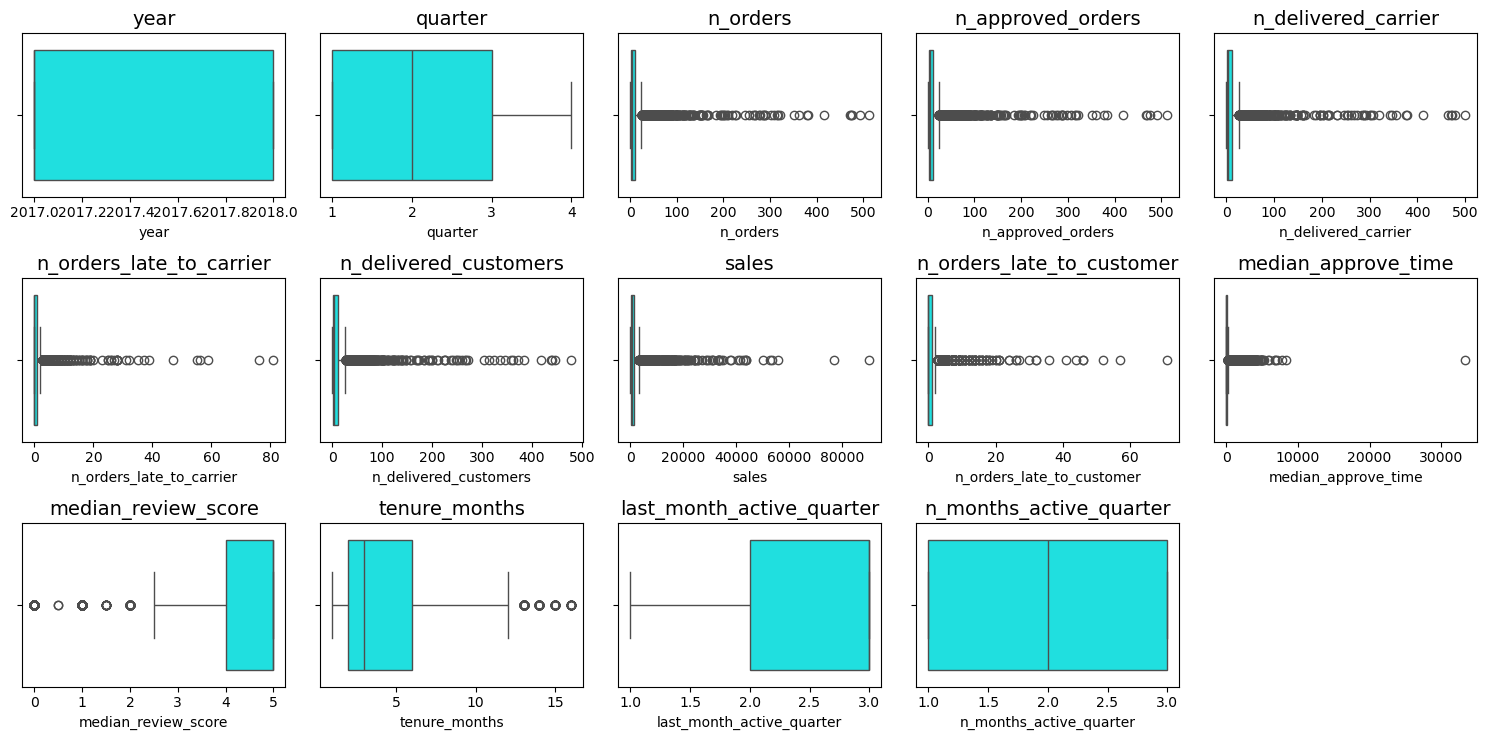

In [25]:
num_cols = 5
num_rows = int(np.ceil(len(numerical_cols) / num_cols))

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 7.5))


axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(data=df, x=col, ax=axes[i], color='cyan')
    axes[i].set_title(col, fontsize=14)

        
for ax in axes[len(numerical_cols):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

From the above graph, it's evident that `n_orders`, `n_approved_orders`, `n_delivered_carrier`, `n_delivered_customer`, and `n_orders_late_to_customer` show significant right skew. **This pattern is common in e-commerce industry where high values for these metrics typically represent high-performing sellers, who constitute a small percentage of the overall seller population.**

`tenure_months` also displays right skew, indicating long-term sellers who have maintained platform presence since early adoption.

`median_review_score` shows left skew, likely correlating with unprofitable sellers as previously discussed in the profitable/unprofitable seller segment analysis.

`n_orders_late_to_carrier` and `n_orders_late_to_customer` exhibit right skew as well, potentially identifying low-performing or unprofitable sellers.

**While these variables contain numerous outliers, they appear to form meaningful clusters that represent actual business patterns rather than data errors. Therefore, we'll retain these outliers**. We will later choose ensemble models, which typically handle such outlier patterns more effectively.

However, for `median_approve_time`, we identified one extreme outlier significantly distant from other values. This represents a single data point that appears anomalous compared to all other observations. We'll remove this record as it likely represents an error rather than a meaningful business pattern for our model.

In [26]:
df.query("median_approve_time > 20000")

,year,quarter,seller_id,is_churn,n_orders,n_approved_orders,n_delivered_carrier,n_orders_late_to_carrier,n_delivered_customers,sales,n_orders_late_to_customer,median_approve_time,median_review_score,tenure_months,last_month_active_quarter,n_months_active_quarter,seller_city,seller_state
seller_active_quarter,,,,,,,,,,,,,,,,,,
2017Q4,2017,4,seller_387,1,1,1,0,0,0,0.0,0,33353.416667,0.0,5,3,1,barra mansa,RJ


In [27]:
df = df.query("median_approve_time <= 20000")

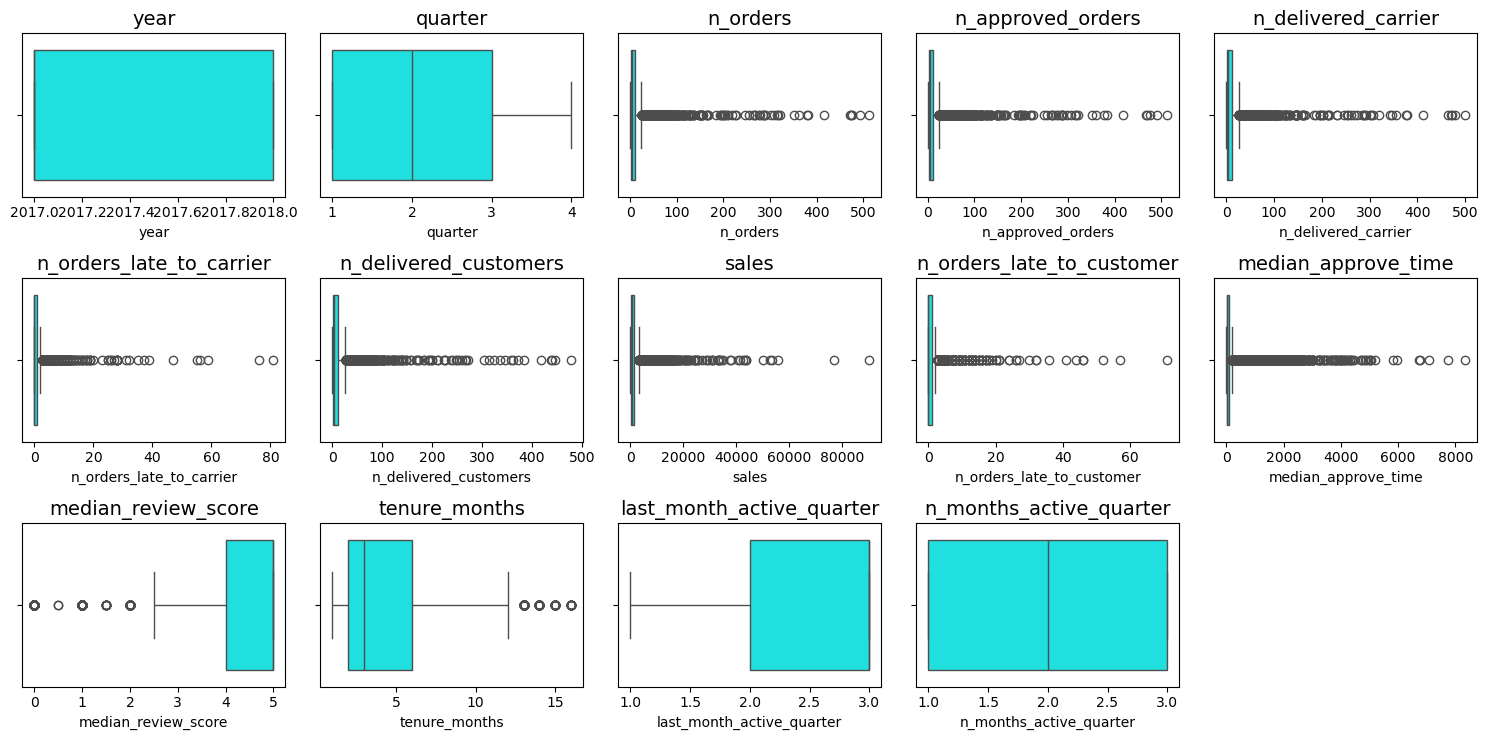

In [28]:
num_cols = 5
num_rows = int(np.ceil(len(numerical_cols) / num_cols))

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 7.5))


axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(data=df, x=col, ax=axes[i], color='cyan')
    axes[i].set_title(col, fontsize=14)

        
for ax in axes[len(numerical_cols):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

## **4.2 Correlated Feature Handling and Feature Engineering**

As can be seen below, some numerical features in our dataset are highly correlated. While this is not a problem for ensemble models such as XGBoost and Random Forest, which are robust to multicollinearity, it can lead to inefficiencies. Specifically, **highly correlated features may result in wasted computation cost and slower model training, especially as the dataset grows in size over time**. 

To address this, in this section, we will **focus on identifying and dropping redundant features** that are highly correlated with other features. Additionally, we will **introduce new, interpretable features designed to minimize correlation with each other**. Our goal is to **ensure that the newly set features have a maximum correlation of 0.80 with one another**, thereby reducing redundancy while maintaining interpretability and model performance.

In [29]:
n_numerical_features_before = df.drop(columns='is_churn').select_dtypes(include=['number']).columns.shape[0] # For comparison below

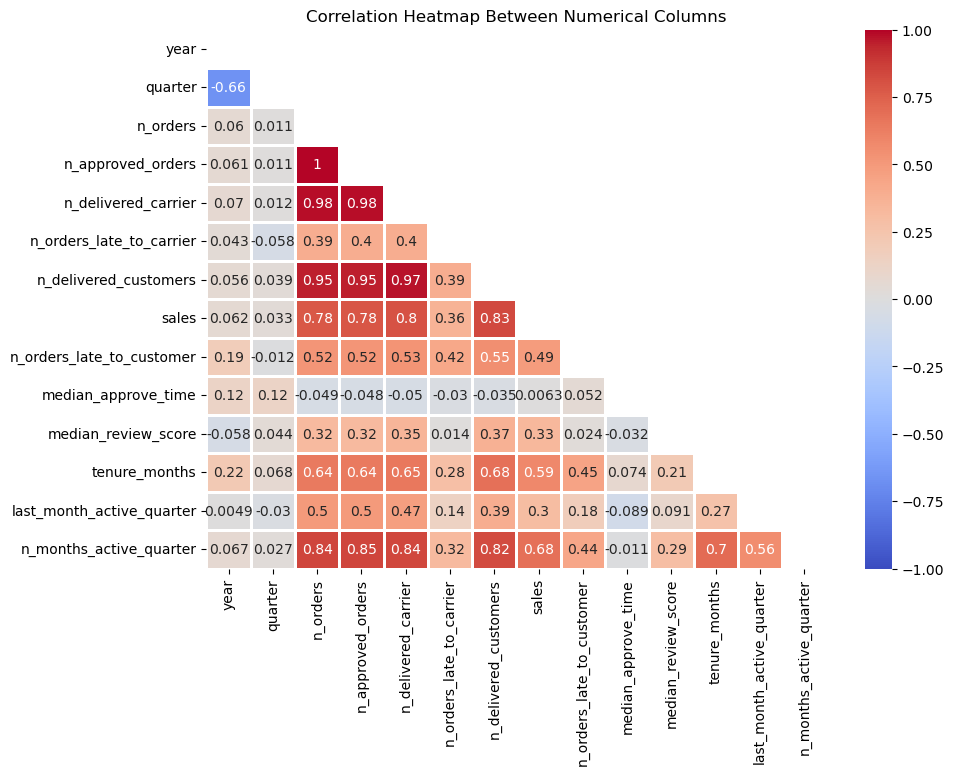

In [30]:
plt.figure(figsize=(10,7))
corr_df = df.drop(columns='is_churn').corr(numeric_only=True, method='spearman') # Most numerical columns are not normally distributed (see prev. section)
mask_for_corr = np.ones_like(corr_df,dtype='bool')
mask_for_corr = np.triu(mask_for_corr) # Set elements of the upper triangle to zeroes (s.t. it's not displayed)

sns.heatmap(corr_df, vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=mask_for_corr, annot=True, linecolor='white', linewidth=1)
plt.xticks(rotation=90)
plt.title("Correlation Heatmap Between Numerical Columns")
plt.show()

The heatmap reveals strong correlations among the order-related features: `n_orders` (the total number of purchases a seller received in a quarter, regardless of approval status), `n_approved_orders`, `n_delivered_carrier`, and `n_delivered_customers`. To address this, we will retain `n_delivered_carrier` and remove the other order features.

/tmp/ipykernel_51155/3064926810.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['n_delivered_customers', 'n_approved_orders', 'n_orders'],inplace=True)


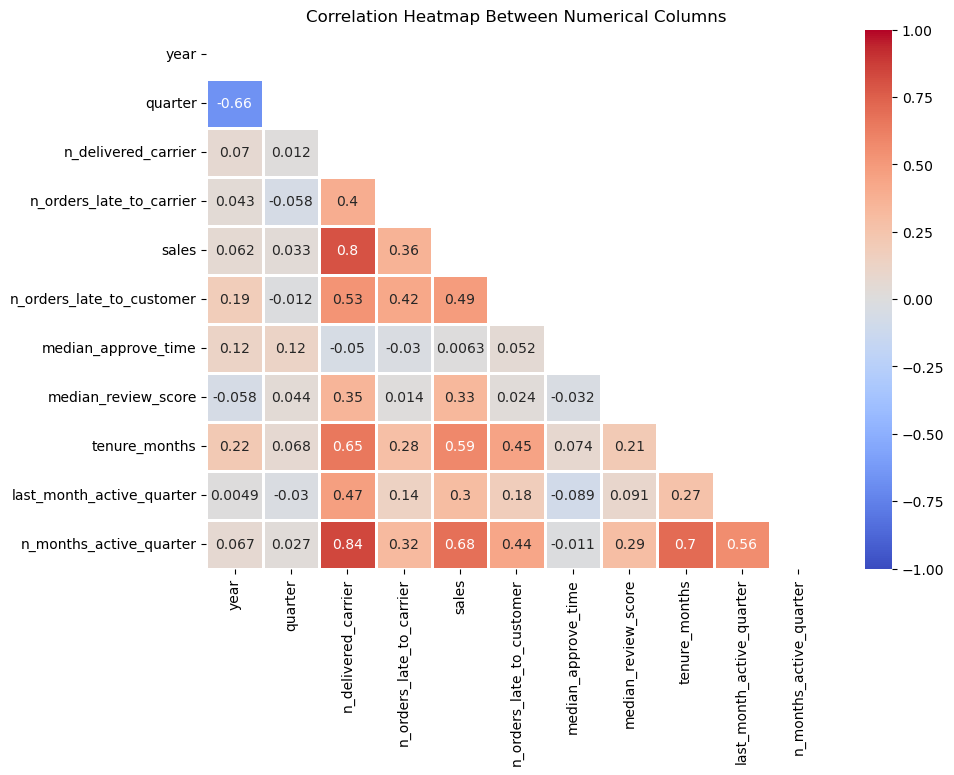

In [31]:
df.drop(columns=['n_delivered_customers', 'n_approved_orders', 'n_orders'],inplace=True)

plt.figure(figsize=(10,7))
corr_df = df.drop(columns='is_churn').corr(numeric_only=True, method='spearman') # Most numerical columns are not normally distributed (see prev. section)
mask_for_corr = np.ones_like(corr_df,dtype='bool')
mask_for_corr = np.triu(mask_for_corr) # Set elements of the upper triangle to zeroes (s.t. it's not displayed)

sns.heatmap(corr_df, vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=mask_for_corr, annot=True, linecolor='white', linewidth=1)
plt.xticks(rotation=90)
plt.title("Correlation Heatmap Between Numerical Columns")
plt.show()

After removing the redundant order-related features, we observe that `n_delivered_carrier` is still highly correlated with `n_months_active_quarter`. To address this, we will create a new, interpretable metric, `n_delivered_carrier_per_active_month`, which divides the number of delivered orders by the number of active months in the quarter. This new feature will replace `n_delivered_carrier` and is calculated as follows:

$$
\text{n\_delivered\_carrier\_per\_active\_month} = \frac{\text{n\_delivered\_carrier}}{\text{n\_months\_active\_quarter}}
$$

/tmp/ipykernel_51155/4088940284.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['n_delivered_carrier'],inplace=True)


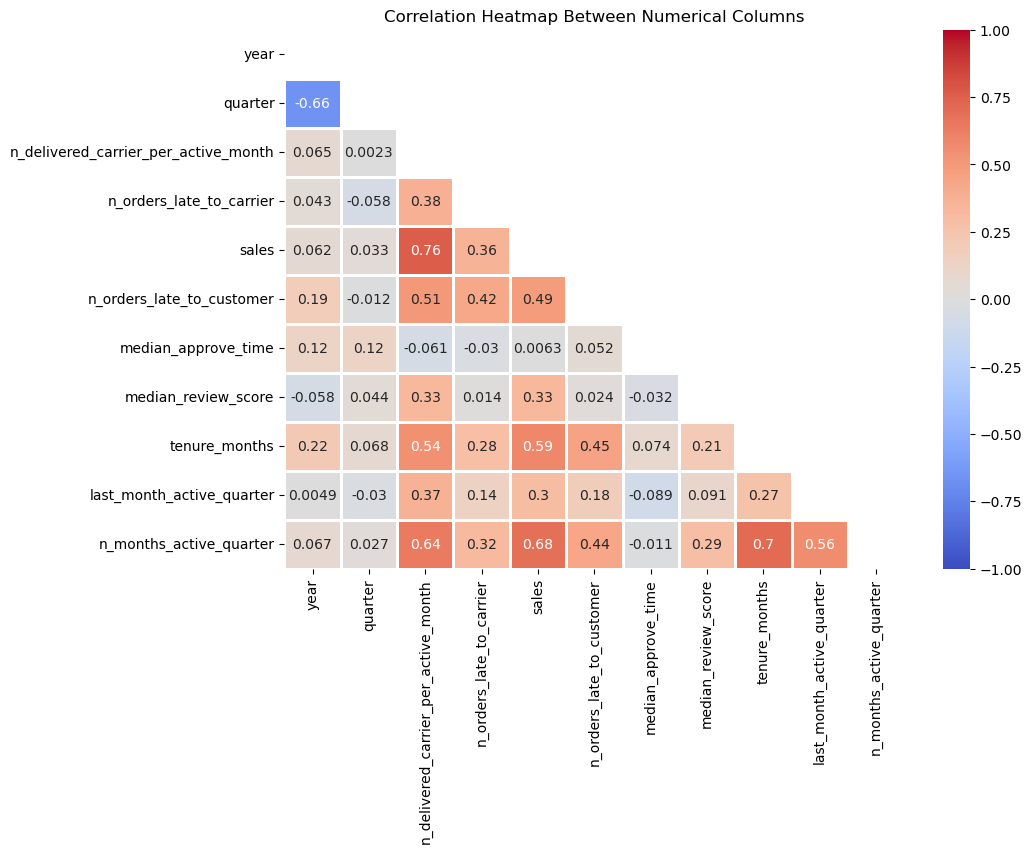

In [32]:
df.insert(loc=2,column='n_delivered_carrier_per_active_month', value=df['n_delivered_carrier'] / df['n_months_active_quarter'])
df.drop(columns=['n_delivered_carrier'],inplace=True)

plt.figure(figsize=(10,7))
corr_df = df.drop(columns='is_churn').corr(numeric_only=True, method='spearman') # Most numerical columns are not normally distributed (see prev. section)
mask_for_corr = np.ones_like(corr_df,dtype='bool')
mask_for_corr = np.triu(mask_for_corr) # Set elements of the upper triangle to zeroes (s.t. it's not displayed)

sns.heatmap(corr_df, vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=mask_for_corr, annot=True, linecolor='white', linewidth=1)
plt.xticks(rotation=90)
plt.title("Correlation Heatmap Between Numerical Columns")
plt.show()

After replacing `n_delivered_carrier` with `n_delivered_carrier_per_active_month`, the updated heatmap shows that **no features exhibit a correlation exceeding 0.80 with one another**. We also have **reduced the number of numerical features from 14 to 11**. This confirms that we have successfully reduced redundancy while maintaining interpretability and adhering to our correlation threshold.


In [33]:
n_numerical_features_after = df.drop(columns='is_churn').select_dtypes(include=['number']).columns.shape[0]
print(f"Number of numerical features BEFORE Correlated Feature Handling and Feature Engineering: {n_numerical_features_before}")
print(f"Number of numerical features AFTER Correlated Feature Handling and Feature Engineering: {n_numerical_features_after}")

Number of numerical features BEFORE Correlated Feature Handling and Feature Engineering: 14
Number of numerical features AFTER Correlated Feature Handling and Feature Engineering: 11


In [34]:
df

,year,quarter,n_delivered_carrier_per_active_month,seller_id,is_churn,n_orders_late_to_carrier,sales,n_orders_late_to_customer,median_approve_time,median_review_score,tenure_months,last_month_active_quarter,n_months_active_quarter,seller_city,seller_state
seller_active_quarter,,,,,,,,,,,,,,,
2017Q1,2017,1,0.000000,seller_1526,0,0,0.00,0,15.466667,0.0,1,3,1,sao paulo,SP
2017Q1,2017,1,10.666667,seller_2743,0,1,4977.69,1,10.650000,5.0,4,3,3,sao paulo,SP
2017Q1,2017,1,1.500000,seller_2382,1,0,84.60,0,0.000000,4.5,2,3,2,sao roque,SP
2017Q1,2017,1,1.000000,seller_1375,0,0,145.00,0,10.216667,4.0,1,2,1,sao paulo,SP
2017Q1,2017,1,1.000000,seller_464,0,0,336.80,0,6.625000,4.5,3,3,2,guarulhos,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018Q1,2018,1,2.000000,seller_458,1,0,167.00,0,24.366667,3.0,1,2,1,sao paulo,SP
2018Q1,2018,1,3.666667,seller_329,0,0,2408.47,4,33.100000,1.0,15,3,3,sao paulo,SP
2018Q1,2018,1,2.000000,seller_1759,0,0,45.99,0,1953.625000,1.0,1,3,1,sao paulo,SP


In [35]:
pd.DataFrame({
    'total': df.shape[0],
    'null_count': df.isna().sum(),
    'null_pct':   [f"{val:.2f}%" for val in (df.isna().sum() / df.shape[0] * 100)],
    'unique_count': df.nunique(),
    'dtype': df.dtypes
}).rename_axis('column')

,total,null_count,null_pct,unique_count,dtype
column,,,,,
year,5123,0,0.00%,2,int64
quarter,5123,0,0.00%,4,int64
n_delivered_carrier_per_active_month,5123,0,0.00%,184,float64
seller_id,5123,0,0.00%,2158,object
is_churn,5123,0,0.00%,2,int64
n_orders_late_to_carrier,5123,0,0.00%,37,int64
sales,5123,0,0.00%,3892,float64
n_orders_late_to_customer,5123,0,0.00%,34,int64
median_approve_time,5123,0,0.00%,3229,float64


# **5. Train-Test Split**

In [36]:
train_data = df.query("index>= '2017Q1' and index < '2018Q1'")
test_data = df.query("index>= '2018Q1' and index < '2018Q2'")

Our previous analysis in notebook "02. Data Cleaning and Analysis" revealed significant variations in order volumes across different cities. This pattern suggests that geographic location, specifically `seller_city`, could serve as a valuable predictor in our model.

However, incorporating `seller_city` directly presents a challenge: the dataset contains numerous unique cities, which would create an excessive number of categorical features after encoding. This would not only increase model complexity but could potentially lead to overfitting and computational inefficiency.

Since `seller_city` is hierarchically nested within `seller_state`, we can capture geographic variation more efficiently by using `seller_state` as our geographic feature. Therefore, we will retain `seller_state` in our feature set and exclude `seller_city` from the model.

In [37]:
X_train, y_train = train_data.drop(columns=['is_churn', 'seller_id', 'seller_city']), train_data['is_churn']
X_test, y_test = test_data.drop(columns=['is_churn', 'seller_id', 'seller_city']), test_data['is_churn']

In [38]:
display(X_train)
display(y_train.value_counts(normalize=True))

,year,quarter,n_delivered_carrier_per_active_month,n_orders_late_to_carrier,sales,n_orders_late_to_customer,median_approve_time,median_review_score,tenure_months,last_month_active_quarter,n_months_active_quarter,seller_state
seller_active_quarter,,,,,,,,,,,,
2017Q1,2017,1,0.000000,0,0.00,0,15.466667,0.0,1,3,1,SP
2017Q1,2017,1,10.666667,1,4977.69,1,10.650000,5.0,4,3,3,SP
2017Q1,2017,1,1.500000,0,84.60,0,0.000000,4.5,2,3,2,SP
2017Q1,2017,1,1.000000,0,145.00,0,10.216667,4.0,1,2,1,SP
2017Q1,2017,1,1.000000,0,336.80,0,6.625000,4.5,3,3,2,SP
...,...,...,...,...,...,...,...,...,...,...,...,...
2017Q4,2017,4,3.000000,2,3182.50,1,374.400000,5.0,2,3,2,SC
2017Q4,2017,4,2.000000,0,658.00,0,13.308333,4.5,3,3,3,PR
2017Q4,2017,4,2.000000,0,437.99,0,8.316667,4.0,3,2,1,SP


is_churn
0    0.761358
1    0.238642
Name: proportion, dtype: float64

In [39]:
display(X_test)
display(y_test.value_counts(normalize=True))

,year,quarter,n_delivered_carrier_per_active_month,n_orders_late_to_carrier,sales,n_orders_late_to_customer,median_approve_time,median_review_score,tenure_months,last_month_active_quarter,n_months_active_quarter,seller_state
seller_active_quarter,,,,,,,,,,,,
2018Q1,2018,1,5.333333,0,1427.00,0,53.150000,5.0,9,3,3,SP
2018Q1,2018,1,4.000000,0,1310.90,0,14.775000,5.0,5,3,3,SP
2018Q1,2018,1,1.000000,1,214.99,1,1210.491667,4.5,9,2,2,SP
2018Q1,2018,1,14.000000,4,7034.83,6,22.425000,5.0,15,3,3,SP
2018Q1,2018,1,4.000000,4,1280.07,2,17.050000,4.0,11,3,3,SP
...,...,...,...,...,...,...,...,...,...,...,...,...
2018Q1,2018,1,2.000000,0,167.00,0,24.366667,3.0,1,2,1,SP
2018Q1,2018,1,3.666667,0,2408.47,4,33.100000,1.0,15,3,3,SP
2018Q1,2018,1,2.000000,0,45.99,0,1953.625000,1.0,1,3,1,SP


is_churn
0    0.758146
1    0.241854
Name: proportion, dtype: float64

As shown above, the ratio of churn to no-churn in both the `y_train` and `y_test` appears to be imbalanced. 

# **6. Preprocessing**

In [40]:
numerical_cols = X_train.select_dtypes(include=['number']).columns
numerical_cols

Index(['year', 'quarter', 'n_delivered_carrier_per_active_month',
       'n_orders_late_to_carrier', 'sales', 'n_orders_late_to_customer',
       'median_approve_time', 'median_review_score', 'tenure_months',
       'last_month_active_quarter', 'n_months_active_quarter'],
      dtype='object')

In [41]:
transformer = ColumnTransformer([
    ('binary', BinaryEncoder(), ['seller_state']),
    ('robust', RobustScaler(), numerical_cols)
], remainder='passthrough')
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('binary', BinaryEncoder(), ['seller_state']),
                                ('robust', RobustScaler(),
                                 Index(['year', 'quarter', 'n_delivered_carrier_per_active_month',
       'n_orders_late_to_carrier', 'sales', 'n_orders_late_to_customer',
       'median_approve_time', 'median_review_score', 'tenure_months',
       'last_month_active_quarter', 'n_months_active_quarter'],
      dtype='object'))])

The transformer used applies two different techniques:

- `BinaryEncoder` converts the categorical 'seller_state' column to binary representation, which is more efficient than one-hot encoding for high-cardinality variables.
- `RobustScaler` scales numerical columns using median and interquartile range, making it resistant to outliers unlike standard scaling.

Any columns not specified are passed through unchanged.

# **7. Model Selection**

For our selection pool, we are focusing on ensemble models due to their robust performance when handling outliers, which are numerous in our dataset. 

Ensemble methods combine multiple models to produce better predictive performance than a simple base model such as Decision Tree or Logistic Regression.

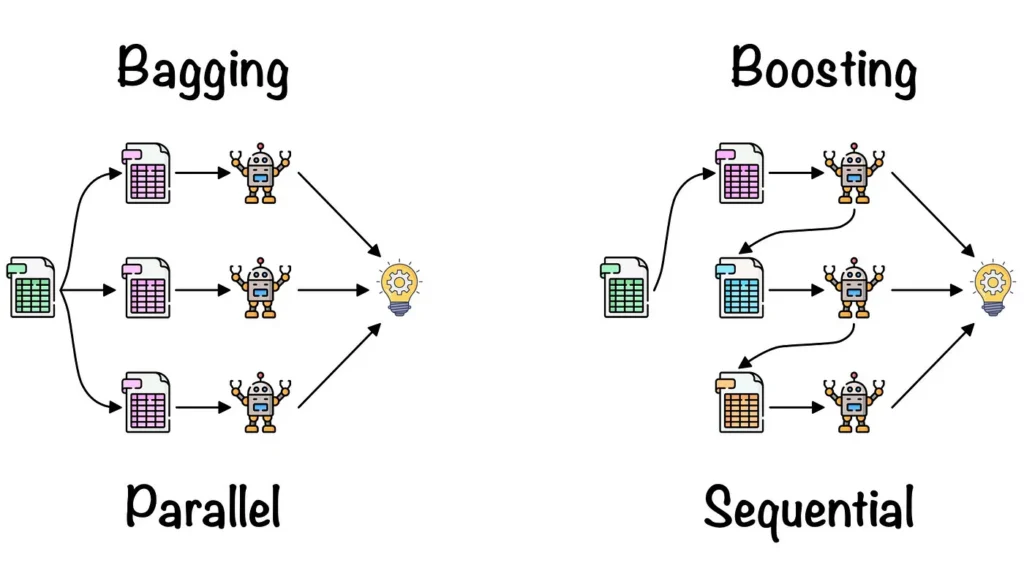


1. **Bagging**:

    Bagging (Bootstrap Aggregating) reduces variance and overfitting by training multiple base models on bootstrapped data subsets, then aggregating predictions via majority voting (classification) or averaging (regression). This stabilizes predictions, especially for high-variance models like decision trees.

   - **RandomForestClassifier**  
        Random Forest operates by constructing multiple decision trees during training and outputting the class that is the mode of the classes of the individual trees. Each tree is built from a bootstrap sample of the training data, and at each node, only a random subset of features is considered for splitting. This randomness helps to create diverse trees, reducing correlation between them and improving the model's ability to handle outliers.

    - **ExtraTreesClassifier**
        Similar to RandomForest, ExtraTreesClassifier builds multiple decision trees. However, it introduces additional randomization: when looking for the best split, it selects random thresholds for each feature rather than searching for the most discriminative threshold. This increases the diversity among trees and can further improve robustness against outliers while reducing overfitting.


2. **Boosting**:

    Boosting reduces bias by training models sequentially, with each model correcting errors of its predecessors. It weights misclassified instances    higher, iteratively building a strong learner that excels on complex datasets.

   - **GradientBoostingClassifier**  
        Gradient Boosting works by building trees sequentially, where each new tree corrects errors made by the previously trained ensemble. It focuses training on instances that were difficult to predict correctly by previous models, effectively giving more weight to challenging cases or outliers. This sequential learning process allows the model to adapt to complex patterns in the data.

    - **XGBoostClassifier**
        XGBoost (Extreme Gradient Boosting) is an optimized implementation of gradient boosting. It offers more hyperparameters to fine-tune (learning rate, tree depth, gamma, alpha/lambda regularization), making it adaptable to diverse situations and data characteristics.


In [42]:
list_model = [RandomForestClassifier(random_state=42),
               ExtraTreesClassifier(random_state=42),
               GradientBoostingClassifier(random_state=42),
               XGBClassifier(random_state=42)]

cv_recall_mean = []
cv_recall_std = []
cv_recall_all = []

for model in list_model:
    gtsplit = GroupTimeSeriesSplit(n_splits=3, test_size=1)

    model_pipe = Pipeline([
        ('prep', transformer), 
        ('model', model)])
    
    model_cv = cross_val_score(
        model_pipe, 
        X_train, 
        y_train, 
        cv = gtsplit, 
        groups = X_train.index,
        scoring = 'recall',
        error_score='raise'
        )

    cv_recall_mean.append(model_cv.mean())
    cv_recall_std.append(model_cv.std())
    cv_recall_all.append(model_cv.round(4))

In [43]:
pd.DataFrame({
    'model': list_model,
    'recall_mean': cv_recall_mean,
    'recall_std': cv_recall_std,
    'recall_cv': cv_recall_all
})

,model,recall_mean,recall_std,recall_cv
0,RandomForestClassifier(random_state=42),0.372854,0.024503,"[0.3636, 0.4064, 0.3485]"
1,ExtraTreesClassifier(random_state=42),0.400338,0.021456,"[0.3939, 0.4292, 0.3779]"
2,GradientBoostingClassifier(random_state=42),0.408628,0.029857,"[0.4495, 0.379, 0.3974]"
3,"XGBClassifier(base_score=None, booster=None, c...",0.422213,0.026537,"[0.4596, 0.4064, 0.4007]"


Our results show that all models exhibit low recall, which is expected given the imbalanced data and model has yet to be tuned. `XGBClassifier` achieved the highest mean recall, with lower standard deviation compared to the second best model, `GradientBoostingClassifier`. For this reason, we will select `XGBClassifier` as our model.

## **7.1 Base Model Initialization**
We will initialize our XGBClassifier with specific parameters to address class imbalance. First, we define `pos_class_weight` as a multiplier that increases the importance of positive class examples during training. 

In [44]:
pos_class_weight = (y_train==0).sum() / (y_train==1).sum() # Initial guess: Ratio between negative to positive class
pos_class_weight

3.1903695408734603

We also initialize the model with `max_delta_step=1`, which constrains the weight updates during training. This parameter helps control model complexity and can improve stability when working with imbalanced datasets by preventing the algorithm from making overly aggressive weight adjustments based on rare positive examples.

In [45]:
pipe_base = Pipeline([
    ('preprocessing', transformer),
    ('model', XGBClassifier(random_state=42, scale_pos_weight=pos_class_weight, max_delta_step=1))
])

pipe_base

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('binary', BinaryEncoder(),
                                                  ['seller_state']),
                                                 ('robust', RobustScaler(),
                                                  Index(['year', 'quarter', 'n_delivered_carrier_per_active_month',
       'n_orders_late_to_carrier', 'sales', 'n_orders_late_to_customer',
       'median_approve_time', 'median_review_score', 'tenure_months',
       'last_...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=1,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [46]:
cv = GroupTimeSeriesSplit(n_splits=3, test_size=1)
scores = cross_val_score(pipe_base, X_train, y_train, groups=X_train.index, scoring='recall', cv=cv)

In [47]:
print(f"Recall CV: {scores}")
print(f"Recall CV Mean:{np.mean(scores)}")

Recall CV: [0.54040404 0.50684932 0.48534202]
Recall CV Mean:0.5108651250055025


In [48]:
pipe_base.fit(X_train, y_train)
y_pred_base = pipe_base.predict(X_test)
recall_train = recall_score(y_train, pipe_base.predict(X_train))
recall_test = recall_score(y_test, y_pred_base)

print(f"Base Model Train Recall: {recall_train}")
print(f"Base Model Test Recall: {recall_test}")

Base Model Train Recall: 0.9988801791713325
Base Model Test Recall: 0.5269461077844312


Our results demonstrate that these adjustments modestly improved the base model's recall, increasing from a `0.4222` recall validation mean during model selection to `0.5109`. 

However, this performance is still far from satisfactory. 

Notably, we observed a significant disparity between the high recall on training data and the low recall on test data, **strongly indicating overfitting**. 

In the following section, we will fine-tune the model's hyperparameters specifically to mitigate this overfitting issue.

# **8. Hyperparameter Tuning**

Hyperparameter tuning will be performed using the `hyperopt` library, leveraging its **TPE (Tree-structured Parzen Estimators)** algorithm via the `fmin` function. This approach is chosen over `sklearn`'s commonly used methods, such as `GridSearchCV` and `RandomizedSearchCV`. Grid search, while thorough, becomes computationally expensive and impractical as the parameter space grows. Random search, on the other hand, can be inconsistent and may miss optimal parameter combinations.

While the syntax for tuning with `hyperopt` is slightly more complicated from that of `sklearn`, the TPE algorithm offers a more advanced method of searching for optimal hyperparameters. **TPE works by building probability models of both good and bad outcomes, then choosing new hyperparameters to test based on which are more likely to give good results**. This adaptive learning process allows TPE to focus its search in promising regions of the parameter space, making it more efficient than both grid and random search. 

In [49]:
from hyperopt import hp, tpe, Trials, space_eval, fmin
from hyperopt.pyll import scope

## **8.1 Parameter Space Definition**

- **`max_depth`**: **The maximum depth of each decision tree**. 

    Possible values: range from `3` to `11` to reduce overfitting.


- **`n_estimators`**: **Number of trees in the ensemble**. 

    Possible values: `[50, 55, 60, ..., 95, 100]` in increments of 5, kept moderately low to prevent overfitting.


- **`learning_rate`**: **Controls how much each tree contributes to the final prediction**. 

    Possible values: logarithmically distributed between `0.01` and `0.2` to make the model learn more conservatively and reduce overfitting.


- **`min_child_weight`**: **Minimum sum of instance weight needed in a child node**. Analogous to `min_samples_split` in Random Forest. 

    Possible values: integers between `10` and `40`, with higher values helping prevent overfitting.


- **`scale_pos_weight`**: **Controls the balance of positive and negative weights**. 

    Possible values: uniformly distributed between `3` and `5`, which are values close to our initial guess in the base model.


- **`max_delta_step`**: **Limits the maximum step each leaf output can take**. 

    Possible values: `[1, 3, 5]`, to prevent the model from making overly aggressive weight adjustments based on rare positive examples.


- **`subsample`**: **Fraction of samples used for each tree**. 

    Possible values: `[0.5, 0.6, 0.7, 0.8, 0.9, 1.0]` is chosen to explore the trade-off between overfitting and underfitting. 

    Lower values (e.g., 0.5) introduce more randomness, reducing overfitting, while higher values (e.g., 1.0) use the full dataset, potentially improving performance on smaller datasets.


- **`colsample_bytree`**: **Fraction of features used for each tree**. 

    Possible values: `[0.5, 0.6, 0.7, 0.8, 0.9, 1.0]` is chosen to explore the trade-off between overfitting and underfitting. 

    Lower values (e.g., 0.5) introduce more randomness, reducing overfitting, while higher values (e.g., 1.0) use the full dataset, potentially improving performance on smaller datasets.

In [50]:
params_space = {
        'max_depth' : hp.choice('max_depth',range(3, 12, 1)), # low values to reduce overfitting
        'n_estimators' : scope.int(hp.quniform("n_estimators", 50, 100,5)), # low values to reduce overfitting
        'learning_rate' : hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)), # low values to reduce overfitting
        'min_child_weight': scope.int(hp.quniform("min_child_weight", 10, 40, 1)), # high values to reduce overfitting
        'scale_pos_weight': hp.uniform("scale_pos_weight", 3, 5), # weight greater than one to accomodate imbalance
        'max_delta_step': hp.choice("max_delta_step", [1,3,5]), # low values to reduce overfitting
        'subsample': hp.choice("subsample", [0.5,0.6, 0.7, 0.8, 0.9, 1.0]),
        'colsample_bytree': hp.choice("colsample_bytree", [0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    }

## **8.2 Objective Function Definition**

In [51]:
def objective(args):
    
    model_pipe = Pipeline([
        ('preprocessing', transformer),
        ('model', XGBClassifier(random_state=42, **args))])
    
    cv = GroupTimeSeriesSplit(n_splits=3, test_size=1)
    model_cv = cross_val_score(
        model_pipe, 
        X_train, 
        y_train, 
        cv = cv,
        groups = X_train.index,
        scoring = 'recall',
        )
    
    loss_score = 1 - model_cv.mean()

    return loss_score

## **8.3 Tuning the Model and Best Parameters**

In [52]:
# Initiate a Trials object 
trials = Trials()

tuning_result = fmin(fn=objective, 
                     space=params_space, 
                     algo=tpe.suggest,
                     max_evals=50, 
                     trials=trials, 
                     rstate=np.random.default_rng(42))

# Best_params from trials
best_params = space_eval(params_space, tuning_result)

100%|██████████| 50/50 [00:10<00:00,  4.55trial/s, best loss: 0.07904254870030603]


In [53]:
best_params

{'colsample_bytree': 1.0,
 'learning_rate': 0.010028600092742812,
 'max_delta_step': 1,
 'max_depth': 10,
 'min_child_weight': 28,
 'n_estimators': 60,
 'scale_pos_weight': 4.865103432344863,
 'subsample': 0.8}

# **9. Model Evaluation**

In [54]:
pipe_tune = Pipeline([
    ('preprocessing', transformer),
    ('model', XGBClassifier(random_state=0, **best_params))
])
pipe_tune.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('binary', BinaryEncoder(),
                                                  ['seller_state']),
                                                 ('robust', RobustScaler(),
                                                  Index(['year', 'quarter', 'n_delivered_carrier_per_active_month',
       'n_orders_late_to_carrier', 'sales', 'n_orders_late_to_customer',
       'median_approve_time', 'median_review_score', 'tenure_months',
       'last_...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.010028600092742812, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=1, max_depth=10, max_leaves=None,
                               min_child_weight=28, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=60, n_jobs=None,
                               num_parallel_tree=None, random_state=0, ...))])

XGB CLASSIFIER PIPELINE AFTER TUNING
CV Recall: [0.9798 0.8858 0.9023]
CV Recall Mean: 0.9226
CV Recall Std: 0.041
Train Recall: 0.9462
Test Recall: 0.9132


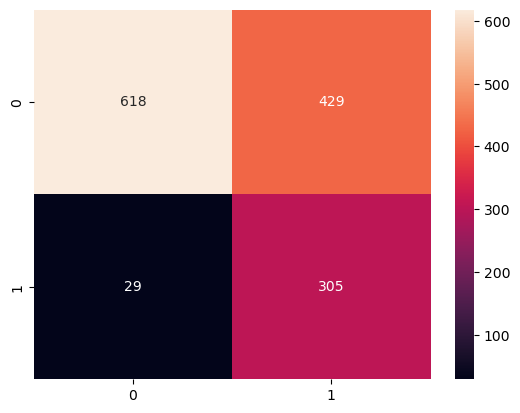

In [55]:
cv_score = cross_val_score(
        pipe_tune, 
        X_train, 
        y_train, 
        cv = cv,
        groups = X_train.index,
        scoring = 'recall',
        )


pipe_tune.fit(X_train, y_train)
y_pred_tune = pipe_tune.predict(X_test)
recall_train = recall_score(y_train, pipe_tune.predict(X_train))
recall_test = recall_score(y_test, y_pred_tune)

print("XGB CLASSIFIER PIPELINE AFTER TUNING")
print(f"CV Recall: {np.round(cv_score,4)}")

print("CV Recall Mean:", np.mean(cv_score).round(4))
print("CV Recall Std:", np.std(cv_score).round(4))
print("Train Recall:", recall_train.round(4))
print("Test Recall:", recall_test.round(4))

sns.heatmap(confusion_matrix(y_test, y_pred_tune), annot=True, fmt='g');

The tuned model demonstrates **substantial improvement** over the initial model, with test recall increasing from `0.5269` to `0.9132`.

Additionally, the **gap between training and test recall has narrowed significantly**, suggesting that the **overfitting** observed in the initial model **has been effectively mitigated through hyperparameter tuning**.

In [56]:
split_recall = pd.DataFrame({
    "Prediction Quarter": ["2017Q2", "2017Q3", "2017Q4", "2018Q1 (Test)"],
    "Recall": np.hstack([cv_score, np.array([recall_test])])*100
})

split_recall

,Prediction Quarter,Recall
0,2017Q2,97.979798
1,2017Q3,88.584475
2,2017Q4,90.228013
3,2018Q1 (Test),91.317365


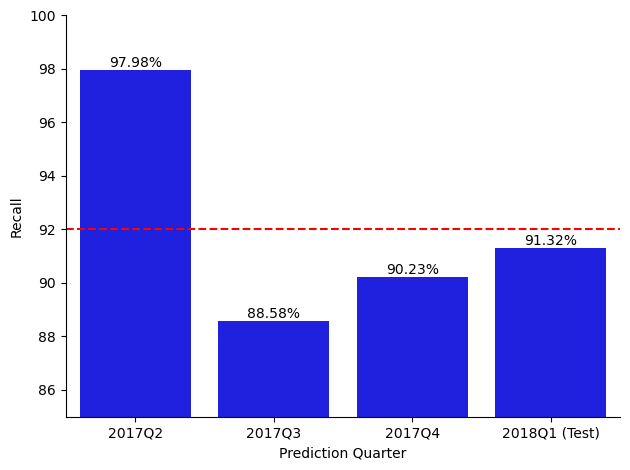

In [57]:
fig, ax = plt.subplots(1)

# Create the barplot
bars = sns.barplot(data=split_recall, x="Prediction Quarter", y="Recall", ax=ax, color='blue')

# Add numbers on top of the bars
for i, bar in enumerate(bars.patches):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%',
            ha='center', va='bottom')

# Set y-axis to start at 85
ax.set_ylim(85, 100)

# Remove top and right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


plt.axhline(split_recall["Recall"].mean(), color = 'red', ls='--')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

plt.show()

The bar chart above displays recall performance across multiple expanding prediction windows from `2017Q2` to `2018Q1`.

`2017Q2` shows exceptionally high recall (`97.98%`), likely due to limited prediction window. A significant drop occurs in `2017Q3` (`88.58%`), which is expected as the initial split only had one quarter to predict `2017Q2`, potentially introducing bias.

Performance stabilizes in the test period (`2017Q3`-`2018Q1`) with recall consistently around 90%. `2017Q4` achieves `90.23%` recall, while `2018Q1` (test data) maintains strong performance at `91.32%.`

**These results demonstrate the model's robust ability to predict out-of-time data**, with stable recall metrics around `92%` average despite the initial volatility.

## **9.1 Prediction Evaluation For Regular and Top Seller Segment**

In [58]:
# For evaluating the metrics later
test_data_copy = test_data[["seller_id", "is_churn"]].copy()
test_data_copy["is_churn_pred"] = y_pred_tune
test_data_copy

,seller_id,is_churn,is_churn_pred
seller_active_quarter,,,
2018Q1,seller_2878,0,0
2018Q1,seller_421,0,0
2018Q1,seller_1696,0,1
2018Q1,seller_67,0,0
2018Q1,seller_1761,0,0
...,...,...,...
2018Q1,seller_458,1,1
2018Q1,seller_329,0,0
2018Q1,seller_1759,0,1


### **9.1.1 Regular Seller Segment**

In [59]:
regular_test_seller_ids

seller_active_quarter
2018Q1    seller_2878
2018Q1     seller_421
2018Q1    seller_1696
2018Q1    seller_1761
2018Q1     seller_316
             ...     
2018Q1    seller_1220
2018Q1    seller_2601
2018Q1     seller_329
2018Q1     seller_180
2018Q1    seller_1021
Freq: Q-DEC, Name: seller_id, Length: 747, dtype: object

In [60]:
test_data_regular = test_data_copy[test_data_copy.seller_id.isin(regular_test_seller_ids)]
test_data_regular

,seller_id,is_churn,is_churn_pred
seller_active_quarter,,,
2018Q1,seller_2878,0,0
2018Q1,seller_421,0,0
2018Q1,seller_1696,0,1
2018Q1,seller_1761,0,0
2018Q1,seller_316,1,1
...,...,...,...
2018Q1,seller_1220,0,1
2018Q1,seller_2601,1,1
2018Q1,seller_329,0,0


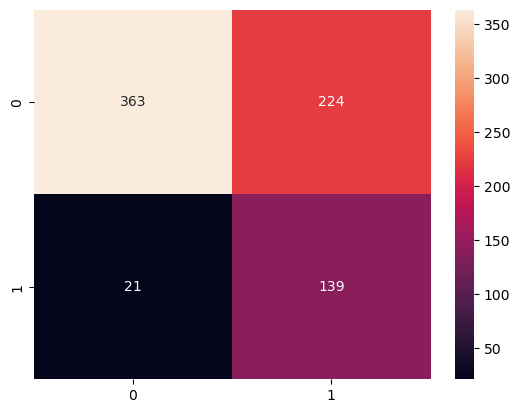

Regular Seller Segment Recall: 0.8688
Regular Seller Segment Accuracy: 0.6720


In [61]:
sns.heatmap(confusion_matrix(test_data_regular["is_churn"], test_data_regular["is_churn_pred"]), annot=True, fmt='g')
plt.show()

top_seller_recall = recall_score(test_data_regular["is_churn"], test_data_regular["is_churn_pred"])
top_seller_accuracy = accuracy_score(test_data_regular["is_churn"], test_data_regular["is_churn_pred"])

print(f"Regular Seller Segment Recall: {top_seller_recall:0.4f}")
print(f"Regular Seller Segment Accuracy: {top_seller_accuracy:0.4f}")

Our model exhibited a good performance in predicting churn within the Regular Seller segment, achieving a recall of `0.8668`. However, this value is approximately 5% lower than the overall recall for the test set (`0.9132`).

In the Regular Seller segment, there is also a significant proportion of false positives, as indicated by the accuracy score of `0.6720`. A similar trend is observed in the overall test set, where false positives are notable, but recall is high. This result is not surprising, given Regular Sellers make up the majority of the sellers in the test set.

### **9.1.2 Top Seller Segment**

In [62]:
top_test_seller_ids

seller_active_quarter
2018Q1      seller_67
2018Q1     seller_797
2018Q1    seller_2001
2018Q1     seller_513
2018Q1    seller_1182
             ...     
2018Q1    seller_1781
2018Q1     seller_120
2018Q1     seller_167
2018Q1    seller_1253
2018Q1    seller_2191
Freq: Q-DEC, Name: seller_id, Length: 187, dtype: object

In [63]:
test_data_top = test_data_copy[test_data_copy.seller_id.isin(top_test_seller_ids)]
test_data_top

,seller_id,is_churn,is_churn_pred
seller_active_quarter,,,
2018Q1,seller_67,0,0
2018Q1,seller_797,0,0
2018Q1,seller_2001,0,0
2018Q1,seller_513,0,1
2018Q1,seller_1182,0,0
...,...,...,...
2018Q1,seller_1781,0,0
2018Q1,seller_120,0,0
2018Q1,seller_167,0,0


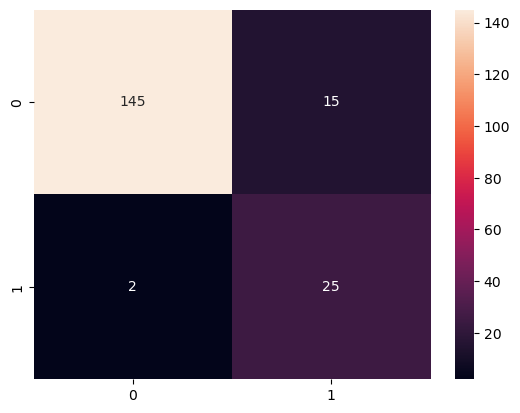

Top Seller Segment Recall: 0.9259
Top Seller Segment Accuracy: 0.9091


In [64]:
sns.heatmap(confusion_matrix(test_data_top["is_churn"], test_data_top["is_churn_pred"]), annot=True, fmt='g')
plt.show()

top_seller_recall = recall_score(test_data_top["is_churn"], test_data_top["is_churn_pred"])
top_seller_accuracy = accuracy_score(test_data_top["is_churn"], test_data_top["is_churn_pred"])

print(f"Top Seller Segment Recall: {top_seller_recall:0.4f}")
print(f"Top Seller Segment Accuracy: {top_seller_accuracy:0.4f}")

Compared to regular seller segment, Our model demonstrated **exceptional performance in predicting churn among top sellers**. 

It achieves **not only a high recall for top sellers (`0.9259`), but also a high accuracy (`0.9091`)**. 

These metrics indicate that both false negatives (FN) and false positives (FP) are minimal for predictions in this group. **Consequently, our model proves to be a valuable tool in achieving our objective of identifying and prioritizing key sellers**.

## **9.2 Cost Reduction From Model**

In [65]:
def calculate_cost(test_data, y_pred, seller_sales_year, fp_cost, fn_cost, tp_cost, segment='top_20_pct'):
    test_df = test_data.copy()[["seller_id", "sales", "is_churn"]]
    test_df["is_churn_pred"] = y_pred
    
    priority_seller_mask = check_priority_sellers(test_df, seller_sales_year, segment)
    test_df_filtered = test_df[priority_seller_mask]

    total_fp_cost = test_df_filtered.query("is_churn == 0 and is_churn_pred == 1").shape[0] * fp_cost
    total_fn_cost = test_df_filtered.query("is_churn == 1 and is_churn_pred == 0").shape[0] * fn_cost
    total_tp_cost = -test_df_filtered.query("is_churn == 1 and is_churn_pred == 1").shape[0] * tp_cost

    return pd.DataFrame({"FN_cost":[total_fn_cost], 'FP_cost':[total_fp_cost], 'TP_cost': [total_tp_cost]})

In [66]:
def summarize_cost(test_data, y_pred, seller_sales_year, top_costs, regular_costs):
    fp_cost_top, fn_cost_top, tp_cost_top = top_costs
    top_seller_cost_summary = calculate_cost(test_data, y_pred, seller_sales_year, fp_cost_top, fn_cost_top, tp_cost_top)
    
    fp_cost_regular, fn_cost_regular, tp_cost_regular = regular_costs
    regular_seller_cost_summary = calculate_cost(test_data, y_pred, seller_sales_year, fp_cost_regular, fn_cost_regular, tp_cost_regular, "regular")

    total_cost_summary = top_seller_cost_summary + regular_seller_cost_summary

    report = f"""
    ---Cost Summary---
        Total False Positive Cost: R${total_cost_summary["FP_cost"][0]}
        Total False Negative Cost: R${total_cost_summary["FN_cost"][0]}
        Total True Positive Cost: R${total_cost_summary["TP_cost"][0]}
        Total Cost: R${total_cost_summary.sum(axis=1)[0]}
    """

    print(report)

In [67]:
top_costs = fp_cost_top, fn_cost_top, tp_cost_top
regular_costs = fp_cost_regular, fn_cost_regular, tp_cost_regular

In [68]:
# Base Model
print("Base Model")
summarize_cost(test_data, y_pred_base, seller_sales_year, top_costs, regular_costs)

Base Model



    ---Cost Summary---
        Total False Positive Cost: R$1080.0
        Total False Negative Cost: R$21513.0
        Total True Positive Cost: R$-379.0
        Total Cost: R$22214.0
    


In [69]:
# Tuned Model
print("Tuned Model")
summarize_cost(test_data, y_pred_tune, seller_sales_year, top_costs, regular_costs)

Tuned Model

    ---Cost Summary---
        Total False Positive Cost: R$4490.0
        Total False Negative Cost: R$3056.0
        Total True Positive Cost: R$-1342.0
        Total Cost: R$6204.0
    


In [70]:
# No Model, No Intervention
print("No Model, No Intervention")
summarize_cost(test_data, np.zeros(test_data.shape[0]), seller_sales_year, top_costs, regular_costs)

No Model, No Intervention

    ---Cost Summary---
        Total False Positive Cost: R$0.0
        Total False Negative Cost: R$30635.0
        Total True Positive Cost: R$0.0
        Total Cost: R$30635.0
    


In [71]:
# No model, Give intervention to all top performing sellers
print("No Model, Give Intervention to All Top Sellers")
summarize_cost(test_data, check_priority_sellers(test_data, seller_sales_year).astype('int64'), seller_sales_year, top_costs, regular_costs)

No Model, Give Intervention to All Top Sellers

    ---Cost Summary---
        Total False Positive Cost: R$24000.0
        Total False Negative Cost: R$13760.0
        Total True Positive Cost: R$-999.0
        Total Cost: R$36761.0
    


The **tuned model** demonstrates superior performance **compared to the base model**:
- Total cost reduction from `22214.0` to `6204.0` (**3.6x cheaper**)
- Better balance between false positives and false negatives

The tuned model also **outperforms using no model and no intervention**:
- No intervention total cost: `30635.0`
- Tuned model total cost: `6204.0`
 This represents a **4.9x cheaper over using no model and no intervention**

The tuned model also performs **better than giving intervention to all top performing sellers**:
- Top sellers intervention total cost: `36761.0`
- Tuned model total cost: `6204.0`
- This represents a **5.9x cheaper over using no model, but intervening with all top performers**

These results clearly show that the tuned model provides significant cost savings and better overall performance compared to all other scenarios tested.

# **10. Model Explanation**

In [72]:
import shap
import re

In [73]:
X_test_transform = pipe_tune['preprocessing'].transform(X_test)
feature_names = pipe_tune['preprocessing'].get_feature_names_out()

In [74]:
feature_names

array(['binary__seller_state_0', 'binary__seller_state_1',
       'binary__seller_state_2', 'binary__seller_state_3',
       'binary__seller_state_4', 'robust__year', 'robust__quarter',
       'robust__n_delivered_carrier_per_active_month',
       'robust__n_orders_late_to_carrier', 'robust__sales',
       'robust__n_orders_late_to_customer', 'robust__median_approve_time',
       'robust__median_review_score', 'robust__tenure_months',
       'robust__last_month_active_quarter',
       'robust__n_months_active_quarter'], dtype=object)

In [75]:
feature_names_convert = [re.sub(r'^(binary__|robust__)', '', col) for col in feature_names]
feature_names_convert = [' '.join(word.capitalize() for word in col.split('_')) for col in feature_names_convert]
feature_names_convert

['Seller State 0',
 'Seller State 1',
 'Seller State 2',
 'Seller State 3',
 'Seller State 4',
 'Year',
 'Quarter',
 'N Delivered Carrier Per Active Month',
 'N Orders Late To Carrier',
 'Sales',
 'N Orders Late To Customer',
 'Median Approve Time',
 'Median Review Score',
 'Tenure Months',
 'Last Month Active Quarter',
 'N Months Active Quarter']

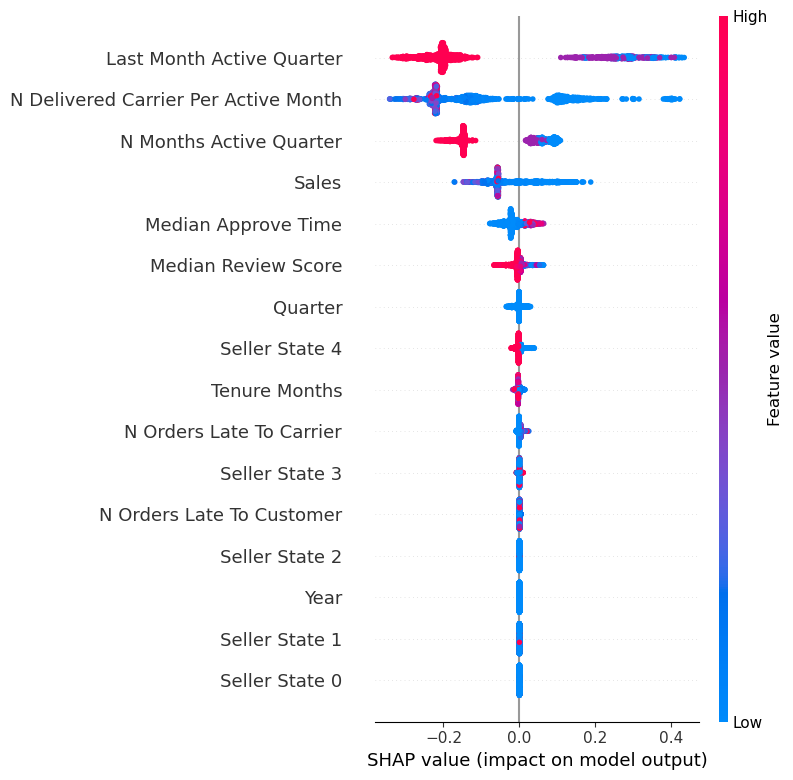

In [76]:
explainer = shap.TreeExplainer(pipe_tune['model'])
shap_values = explainer.shap_values(X_test_transform)

# Create the beeswarm plot
plt.figure(figsize=(10,30))
shap.summary_plot(shap_values, X_test_transform, feature_names=feature_names_convert)

plt.show()

Based on SHAP value analysis, we've identified the six most influential features driving our prediction accuracy:

* **Last Month Active Quarter**:

    The strongest predictor of seller churn is recent platform activity. Sellers who were inactive during the most recent quarter show significantly higher probability of churning. This temporal engagement signal outperforms all other metrics. The data shows a clear threshold effect where sellers falling below a certain delivery volume are at substantially higher risk of churning.

* **N Delivered Carrier Per Active Month**:

    Delivery frequency strongly correlates with seller retention. The more orders a seller delivers to carriers in a quarter, the less likely they are to churn.

* **N Months Active Quarter**:

    Consistency of activity within quarters is critical. Sellers maintaining regular presence across multiple months demonstrate much lower churn rates than those with sporadic engagement patterns.

* **Sales**:

    Interestingly, while sales does impact churn probability, it ranks only fourth in importance. Higher sales correlate with lower churn, but the relationship is less influential than activity-based metrics.

* **Median Approve Time**

    Operational efficiency metrics show moderate impact. The data suggests an optimal range for order approval times, with outliers on either end showing increased churn risk.

* **Median Review Score**

    Customer satisfaction metrics round out the top features. Lower review scores correlate with higher churn probability, confirming the importance of positive customer experiences for seller retention.


# **11. Model Limitation**

- The model can only generate predictions up to 3 months into the future.

- A complete quarter of data is required before the model can predict seller churn for the following quarter. For example, if we're currently in the second month of `2018Q3`, we cannot yet predict churn for `2018Q4`.

- The model is constrained to the specific features used during training. Incorporating new features would require building and training a new model.

- While the model demonstrates high recall for both top and regular sellers,  Regular sellers show a higher false positive errors.

- Predictions are most reliable within the variable ranges present in the training dataset. For instance, the model may be less accurate when predicting outcomes for sellers with median approval times exceeding 20,000 minutes, as such outliers were removed during preprocessing.

- Despite these limitations, out-of-time validation demonstrates strong overall model performance.

# 12. **Conclusion**

- We segmented sellers into **profitable** and **unprofitable** categories, determining that **unprofitable sellers should not be prioritized for churn intervention efforts**.

- Among profitable sellers, we further classified them as **Top** or **Regular** sellers. Top sellers are defined as those in the highest 20% of total sales (measured over the previous year) among all active sellers in a given quarter.

- We developed a classification model using XGBoost to predict seller churn, using recall as our primary optimization metric due to the high cost of false negatives. **Through tuning, we improved the model's recall from a baseline of `0.5269` to `0.9132`.**

- The tuned model demonstrates **robust performance on out-of-time data, achieving an average recall of 0.92 across all prediction windows**.

- The optimized model achieves **high recall for both Regular (`0.8688`) and Top sellers (`0.9259`)**, though Regular sellers exhibits more false positive errors.

- The model **performs exceptionally well for Top sellers, with both high recall (`0.9259`) and high accuracy (`0.9091`)**, making it particularly effective at predicting churn within this valuable segment.

- **Our tuned model delivers significant cost efficiencies across multiple comparison scenarios**: it reduces total costs from R$22,214 to R$6,204 compared to the base model (**3.6x cheaper**), outperforms using no intervention (R$30,635 vs R$6,204, representing **4.9x savings**), and proves far more cost-effective than blanket intervention for all top sellers (R$36,761 vs R$6,204, or **5.9x cheaper**).

# **13. Recommendations**

- Prioritize top sellers with our model, as its performance suggests targeting will be applied effectively.

- Consider reducing incentives for regular sellers below initial cost assumptions, given the model's higher false positive rate in this segment.

- Further segment regular sellers to address the notable false positive errors within this group. Develop tailored targeting interventions for each new segment.

- Direct account managers using the model to focus on the three highest-impact features: the last active month in a quarter, delivered orders per active month in that quarter, and total active months in that quarter.

- Initiate cross-departmental discussions on retention strategies for priority sellers.

- Validate the model quarterly and re-train with new data to maintain model quality.

- Conduct economic evaluations of the model's performance after retention campaign to measure ROI and business impact.


# **14. Export model trained with all data**

In [77]:
X, y = df.drop(columns=['is_churn', 'seller_id', 'seller_city']), df['is_churn']
pipe_tune.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('binary', BinaryEncoder(),
                                                  ['seller_state']),
                                                 ('robust', RobustScaler(),
                                                  Index(['year', 'quarter', 'n_delivered_carrier_per_active_month',
       'n_orders_late_to_carrier', 'sales', 'n_orders_late_to_customer',
       'median_approve_time', 'median_review_score', 'tenure_months',
       'last_...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.010028600092742812, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=1, max_depth=10, max_leaves=None,
                               min_child_weight=28, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=60, n_jobs=None,
                               num_parallel_tree=None, random_state=0, ...))])

In [78]:
import pickle

# Get absolute path for cross-platform compatibility
base_dir = os.path.abspath(os.getcwd())  # Ensures script works regardless of where it's run

# Define dataset folder path
folder_path = os.path.join(base_dir, "dataset", "04_deployment_data")

# Create folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

# Define full file path for saving the model
model_path = os.path.join(folder_path, "seller_churn_XGB.sav")

# Save the model using pickle
with open(model_path, 'wb') as file:
    pickle.dump(pipe_tune, file)

print(f"Model saved successfully at: {model_path}")

Model saved successfully at: /home/user/Documents/Purwadhika/FINPRO/Finpro GITHUB/dataset/04_deployment_data/seller_churn_XGB.sav
